# Detecting active ranges 

Here we examine, how a modestly deep network of dense layers is able to recognize the fact that a single feature influences the prediction only when it is within a certain range.

In [1]:
%matplotlib inline

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

### Creating the data

Guaranteeing reproducible results by seeding all random number generators. Thanks for the enlightening advice, [Aurelion Geron](https://www.youtube.com/watch?v=Ys8ofBeR2kA)

In [3]:
def seed_random(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.set_random_seed(seed)

In [24]:
seed_random(40)

This creates a feature 'x' with a noisy influence on the label 'y'

In [25]:
def create_data_frame(function, left, right, size, noisy=None):
    import numpy as np
    import pandas as pd

    if noisy == None:
        noisy = lambda x: x
    x_data = np.random.uniform(low=left, high=right, size=size)
    y_data = noisy(function(x_data))
    return pd.DataFrame({'x': x_data, 'y': y_data})

In [26]:
noisy=lambda x: x+ np.random.normal(loc=0.0, scale=.02, size=len(x))

In [27]:
def rangind(bl, br):
    def _f(x):
        return (np.sign(x-bl+.01)+1) * (np.sign(br - x+.01)+1)/4.0
    return _f

In [28]:
fn = lambda x: rangind(-.5, -.2)(x) + rangind(.2,.5)(x)
#fn = lambda x: rangind(-1, 0)(x)

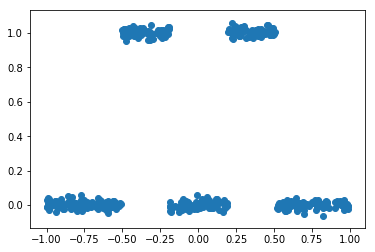

In [29]:
df = create_data_frame(fn, -1, 1, 400, noisy)
x_input = list(df['x'])
x_input = np.reshape(x_input, (-1, 1)) # cosmetics for the neural network
y_input = list(df['y'])
y_input = np.reshape(y_input, (-1, 1)) # cosmetics for the neural network
plt.scatter(list(df['x']),list(df['y']));

The feature $x$ on the x-Axis has an influence on the to-be-predicted observable $y$ only if it is between -0.2 and -0.5 or between 0.2 and 0.5  

---
### The hypothesis
Here, you define your hypothesis as a neural network function

In [30]:
x_p=tf.placeholder(shape=(None, 1), dtype=tf.float32)
y_p=tf.placeholder(shape=(None, 1), dtype=tf.float32)

In [31]:
lrelu = lambda x: tf.nn.leaky_relu(alpha=.02, features=x)

In [32]:
def dnn(units, inp):
    _inp = inp
    for u in units:
        l = tf.layers.Dense(units=u, activation=lrelu)
        _inp = l(_inp)
    return _inp

In [33]:
h = dnn([4,4,4,1], x_p)

---
### Start the training

The result of the training will vary significantly, depending on the seed you chose. For
$seed=42$, the neural network will miss the second active range. With $seed=39$, it misses the first one. With $seed=40$, it will detect both active ranges. This illustrates that - unlike networks with a very large number of parameters - small networks may indeed converge into local minima.

The following cell is again to guarantee reproducibility

In [34]:
config = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1)

In [35]:
init = tf.global_variables_initializer()

In [36]:
loss=tf.losses.mean_squared_error(y_p, h)

In [37]:
optimizer=tf.train.GradientDescentOptimizer(learning_rate=.01)
train_op = optimizer.minimize(loss=loss)

0.035434004


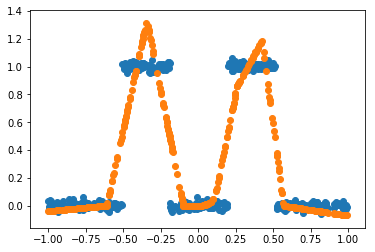

In [40]:
with tf.Session(config=config) as sess:
    sess.run(init)
    for _ in range(10000):
        _, loss_r = sess.run([train_op, loss], feed_dict={x_p: x_input, y_p: y_input})

    y, y_ = sess.run([h, y_p], feed_dict={x_p: x_input, y_p: y_input})


print(loss_r)

y=[l[0] for l in list(y)]
y_=[l[0] for l in list(y_)]

plt.scatter(x_input, y_)
plt.scatter(x_input, y)

Sometimes a system's properties don't depend linearly on a seemingly linear factor. If x is for example a frequency that appears to have a linear influence on the life time of a machine, then it's possible that it's impact increases drastically in the vicinity of the system's other eigenfrequencies. The same may happen when you happen to have chosen daytime of day of month as a linear feature.  